In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from classes.QLearningAgentClass import QLearningAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON, readJSON

In [2]:
shape="14x14"

env = createNNEnv(shape)

Loading models...
Models loaded


In [3]:
# hyperparameters
if shape == "5x5":
    n_episodes = 5000
elif shape == "14x14":
    n_episodes = 15000


train = True            # train or test
show_stats = False       # show stats
export_to_JSON = True   # write JSON file
render = True           # render the results after training

NUM_AGENTS = 50

learning_rate = 0.02
start_epsilon = 1.0
epsilon_decay = start_epsilon/(n_episodes/2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95

agents_arr = []
starting_positions = []

In [4]:
if train:
    print("Starting training of", NUM_AGENTS, "Q-learning agents")

    for i in range(NUM_AGENTS):
        print("Agent", i+1, "/", NUM_AGENTS)

        #env.unwrapped.randomize_start_pos()
        agent = QLearningAgent(env, n_episodes, learning_rate, start_epsilon, epsilon_decay, final_epsilon, discount_factor)
        agent.env.unwrapped.randomize_start_pos()
        agent.train()
        
        agents_arr.append(agent)
        starting_positions.append(agent.env.unwrapped.start_pos)

Starting training of 50 Q-learning agents
Agent 1 / 50


100%|██████████| 15000/15000 [05:12<00:00, 47.96it/s] 


Agent 2 / 50


100%|██████████| 15000/15000 [06:47<00:00, 36.80it/s] 


Agent 3 / 50


100%|██████████| 15000/15000 [04:29<00:00, 55.66it/s] 


Agent 4 / 50


100%|██████████| 15000/15000 [04:40<00:00, 53.57it/s] 


Agent 5 / 50


100%|██████████| 15000/15000 [04:45<00:00, 52.48it/s] 


Agent 6 / 50


100%|██████████| 15000/15000 [04:34<00:00, 54.57it/s] 


Agent 7 / 50


100%|██████████| 15000/15000 [04:19<00:00, 57.89it/s] 


Agent 8 / 50


100%|██████████| 15000/15000 [04:12<00:00, 59.40it/s] 


Agent 9 / 50


100%|██████████| 15000/15000 [04:43<00:00, 52.92it/s] 


Agent 10 / 50


100%|██████████| 15000/15000 [06:35<00:00, 37.95it/s] 


Agent 11 / 50


100%|██████████| 15000/15000 [04:48<00:00, 51.92it/s] 


Agent 12 / 50


100%|██████████| 15000/15000 [04:24<00:00, 56.62it/s] 


Agent 13 / 50


100%|██████████| 15000/15000 [04:30<00:00, 55.44it/s] 


Agent 14 / 50


100%|██████████| 15000/15000 [04:28<00:00, 55.97it/s] 


Agent 15 / 50


100%|██████████| 15000/15000 [04:42<00:00, 53.01it/s] 


Agent 16 / 50


100%|██████████| 15000/15000 [04:33<00:00, 54.94it/s] 


Agent 17 / 50


100%|██████████| 15000/15000 [04:33<00:00, 54.77it/s] 


Agent 18 / 50


100%|██████████| 15000/15000 [04:35<00:00, 54.47it/s] 


Agent 19 / 50


100%|██████████| 15000/15000 [04:44<00:00, 52.63it/s] 


Agent 20 / 50


100%|██████████| 15000/15000 [04:41<00:00, 53.22it/s] 


Agent 21 / 50


100%|██████████| 15000/15000 [04:33<00:00, 54.85it/s] 


Agent 22 / 50


100%|██████████| 15000/15000 [04:22<00:00, 57.05it/s] 


Agent 23 / 50


100%|██████████| 15000/15000 [04:23<00:00, 56.83it/s] 


Agent 24 / 50


100%|██████████| 15000/15000 [04:42<00:00, 53.02it/s] 


Agent 25 / 50


100%|██████████| 15000/15000 [04:35<00:00, 54.40it/s] 


Agent 26 / 50


100%|██████████| 15000/15000 [04:13<00:00, 59.09it/s] 


Agent 27 / 50


100%|██████████| 15000/15000 [06:34<00:00, 38.02it/s] 


Agent 28 / 50


100%|██████████| 15000/15000 [04:49<00:00, 51.86it/s] 


Agent 29 / 50


100%|██████████| 15000/15000 [04:23<00:00, 56.94it/s] 


Agent 30 / 50


100%|██████████| 15000/15000 [04:33<00:00, 54.85it/s] 


Agent 31 / 50


100%|██████████| 15000/15000 [04:17<00:00, 58.23it/s] 


Agent 32 / 50


100%|██████████| 15000/15000 [06:49<00:00, 36.62it/s] 


Agent 33 / 50


100%|██████████| 15000/15000 [04:24<00:00, 56.74it/s] 


Agent 34 / 50


100%|██████████| 15000/15000 [06:45<00:00, 36.99it/s] 


Agent 35 / 50


100%|██████████| 15000/15000 [04:49<00:00, 51.86it/s] 


Agent 36 / 50


100%|██████████| 15000/15000 [04:36<00:00, 54.32it/s] 


Agent 37 / 50


100%|██████████| 15000/15000 [04:52<00:00, 51.31it/s] 


Agent 38 / 50


100%|██████████| 15000/15000 [04:37<00:00, 53.99it/s] 


Agent 39 / 50


100%|██████████| 15000/15000 [04:27<00:00, 56.03it/s] 


Agent 40 / 50


100%|██████████| 15000/15000 [04:29<00:00, 55.71it/s] 


Agent 41 / 50


100%|██████████| 15000/15000 [06:29<00:00, 38.47it/s] 


Agent 42 / 50


100%|██████████| 15000/15000 [06:32<00:00, 38.24it/s] 


Agent 43 / 50


100%|██████████| 15000/15000 [04:17<00:00, 58.29it/s] 


Agent 44 / 50


100%|██████████| 15000/15000 [06:30<00:00, 38.41it/s] 


Agent 45 / 50


100%|██████████| 15000/15000 [04:26<00:00, 56.23it/s] 


Agent 46 / 50


100%|██████████| 15000/15000 [04:25<00:00, 56.55it/s] 


Agent 47 / 50


100%|██████████| 15000/15000 [06:28<00:00, 38.61it/s] 


Agent 48 / 50


100%|██████████| 15000/15000 [04:34<00:00, 54.72it/s] 


Agent 49 / 50


100%|██████████| 15000/15000 [06:24<00:00, 38.96it/s] 


Agent 50 / 50


100%|██████████| 15000/15000 [06:44<00:00, 37.12it/s] 


In [5]:
if train and show_stats:
    for i in range(len(agents_arr)):
        fig = agent.plot_results()
        fig.suptitle(f'Agent {i+1} - Stats')
        plt.show()

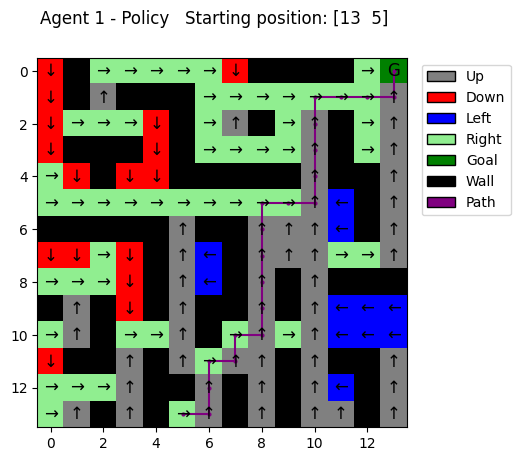

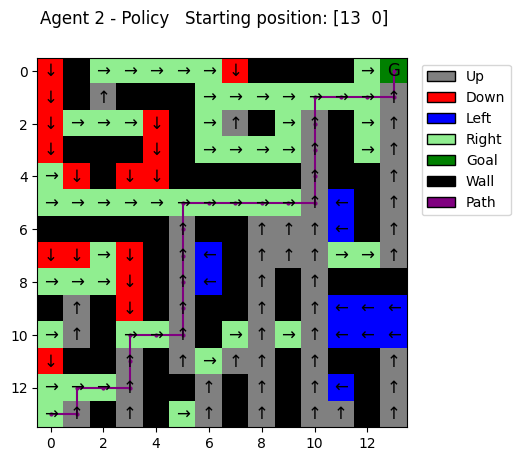

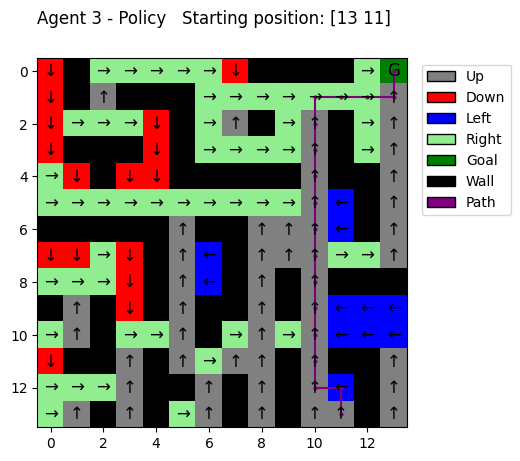

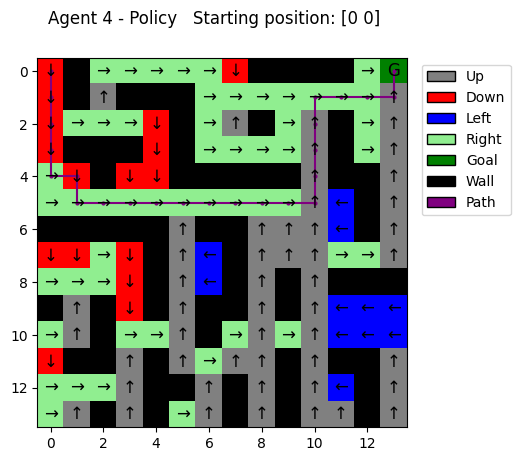

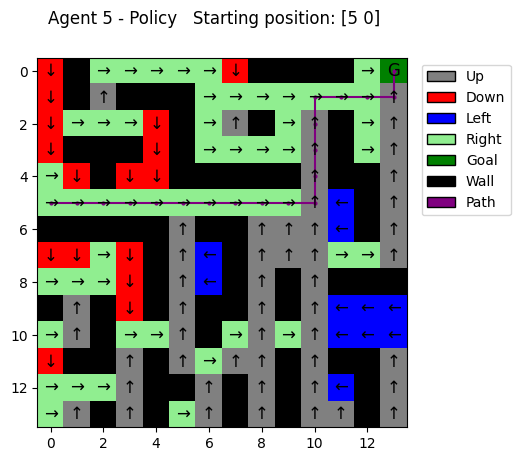

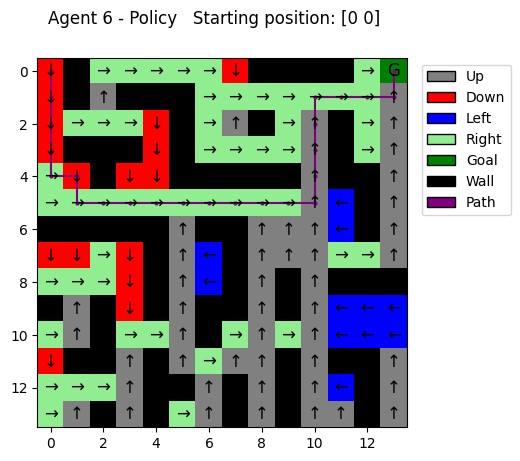

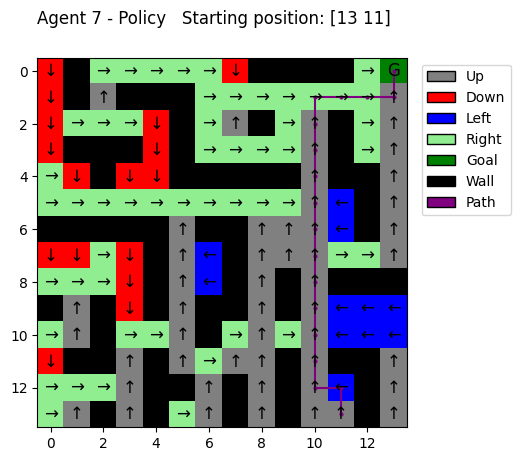

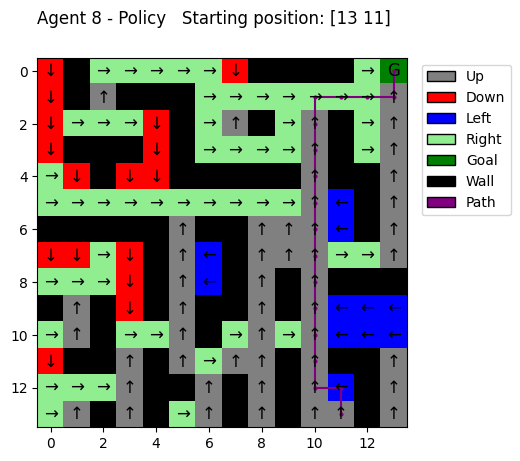

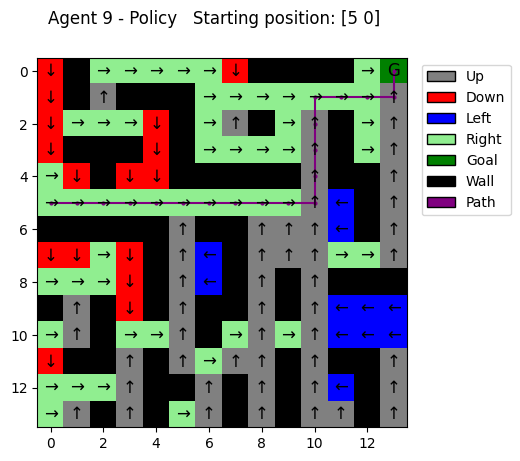

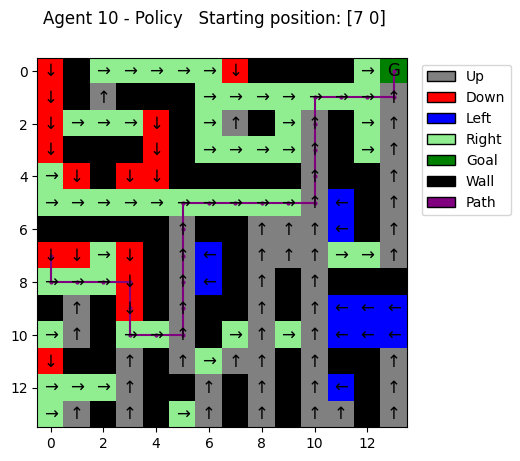

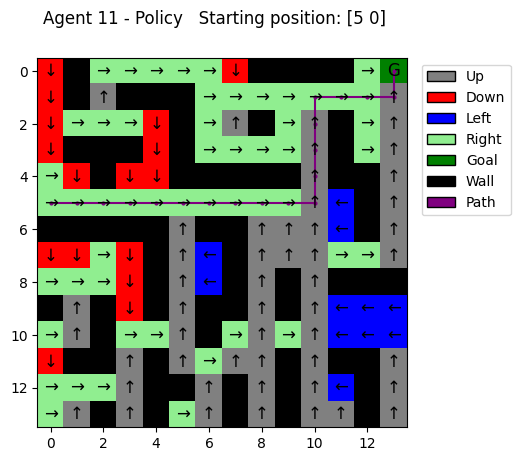

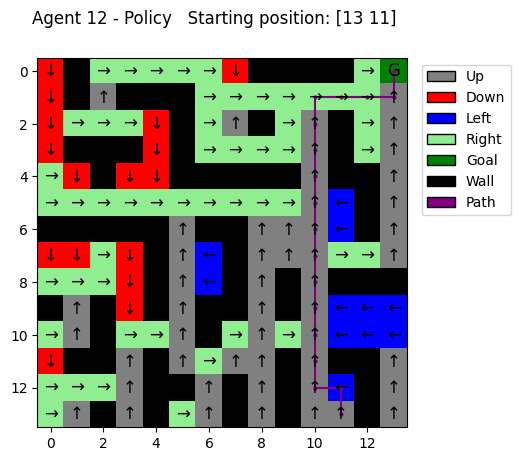

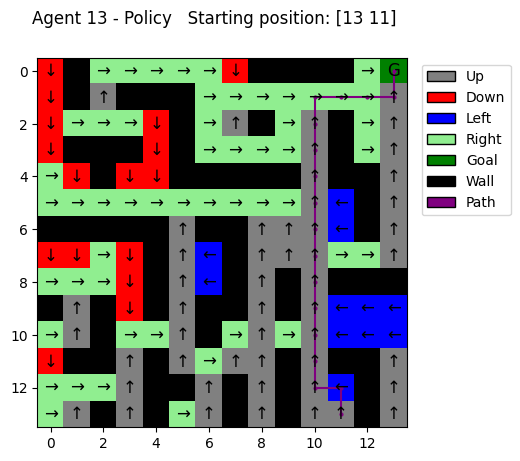

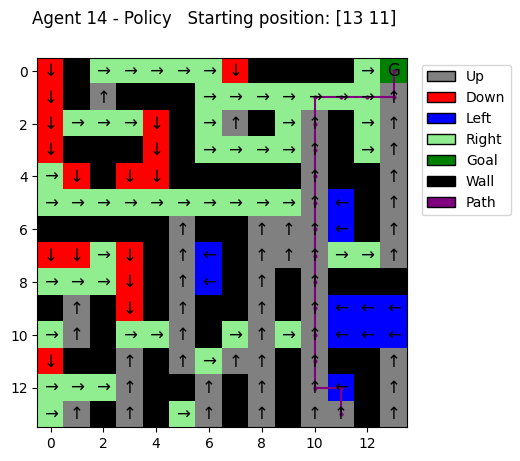

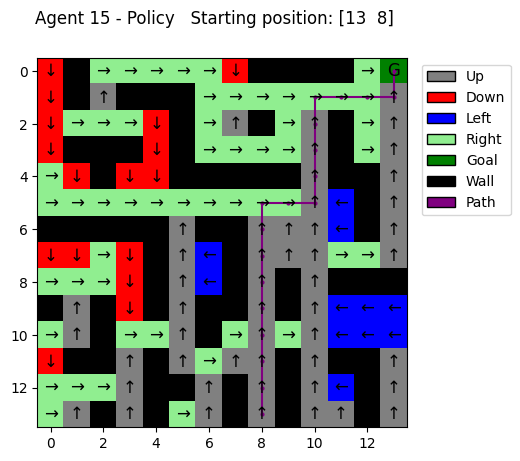

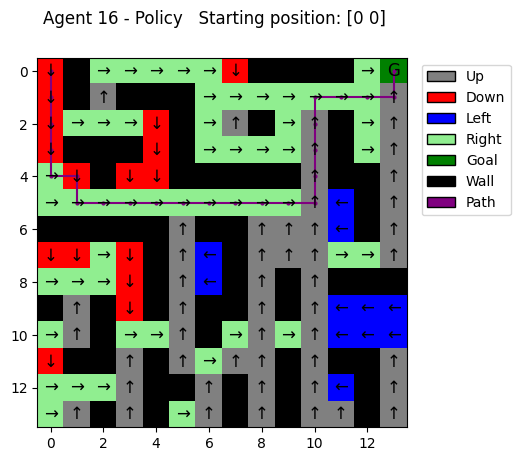

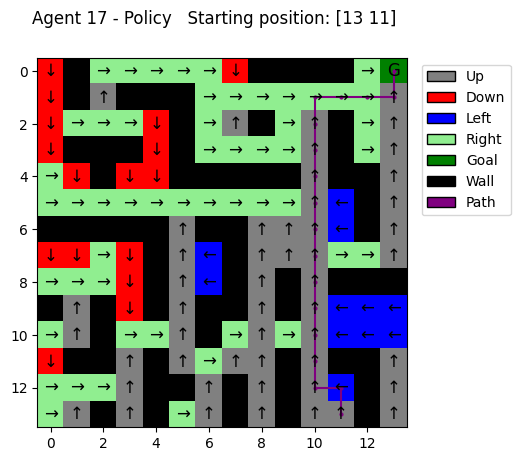

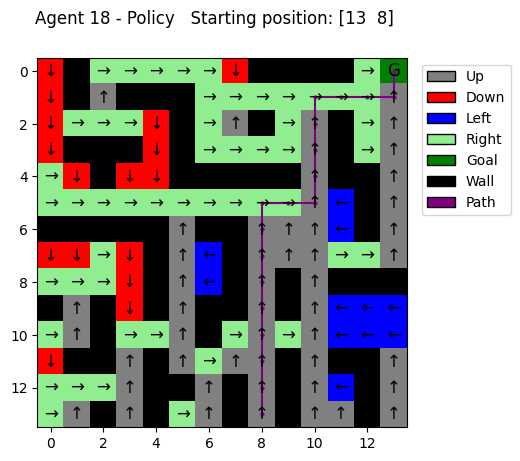

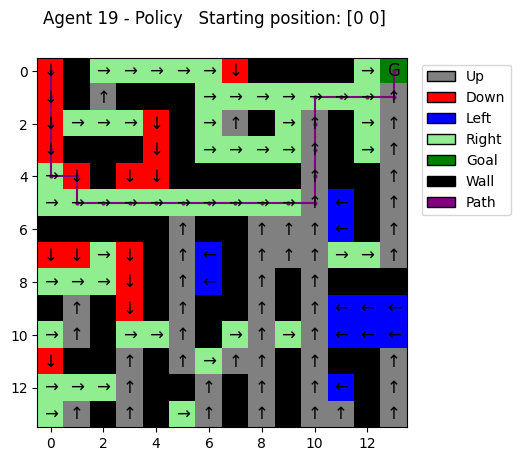

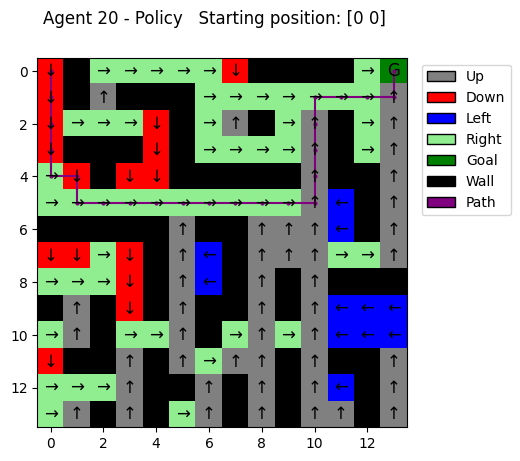

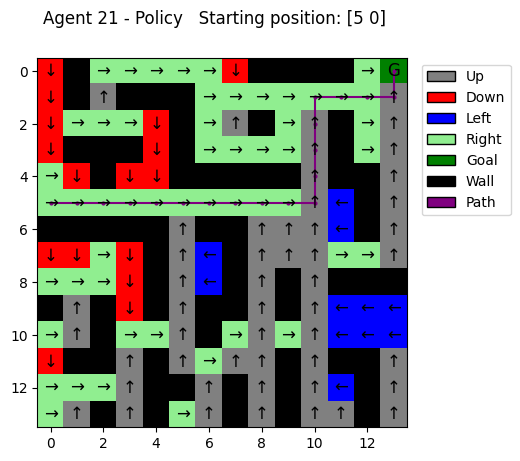

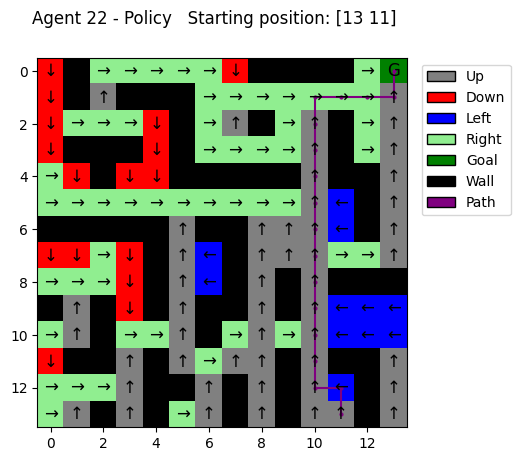

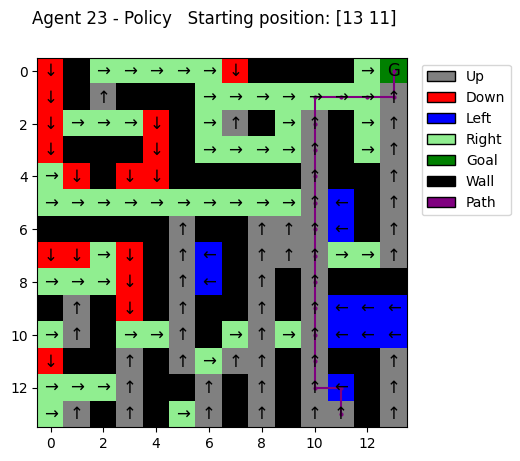

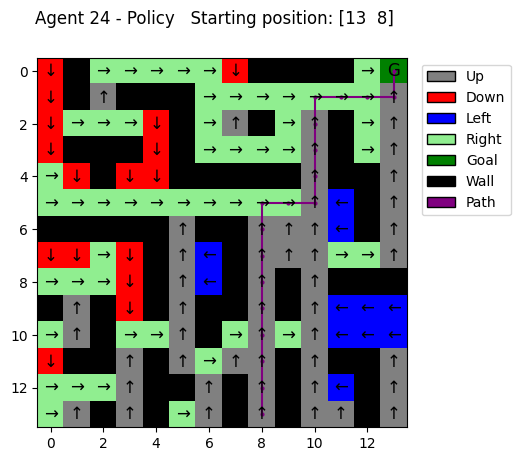

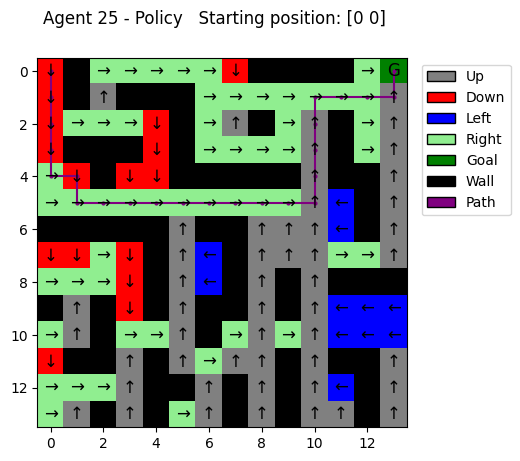

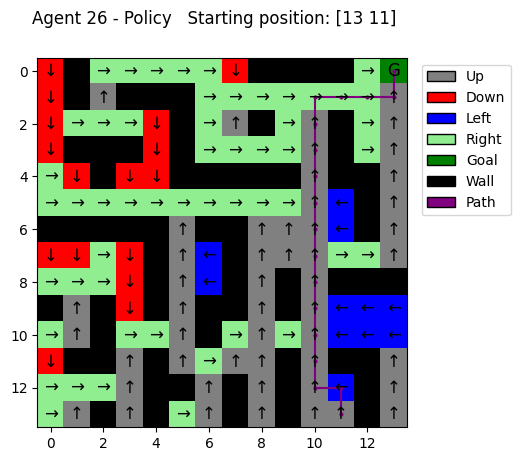

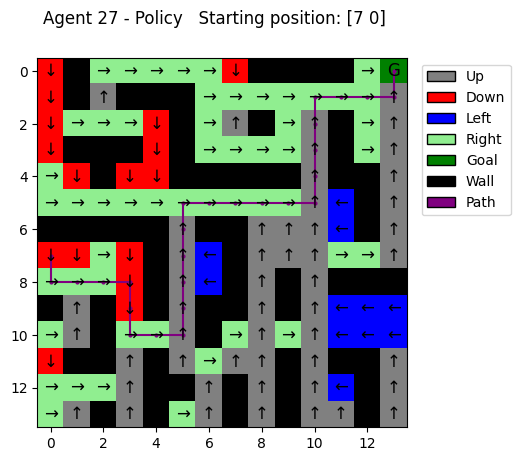

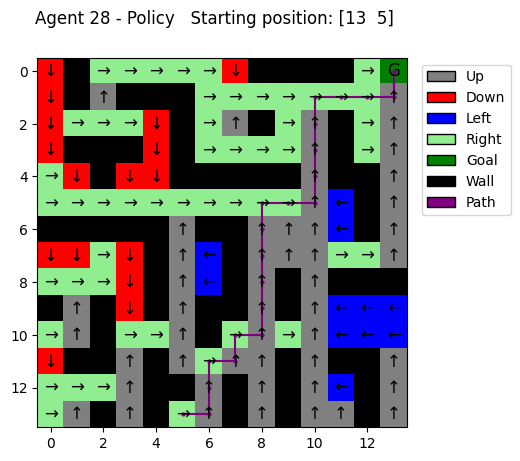

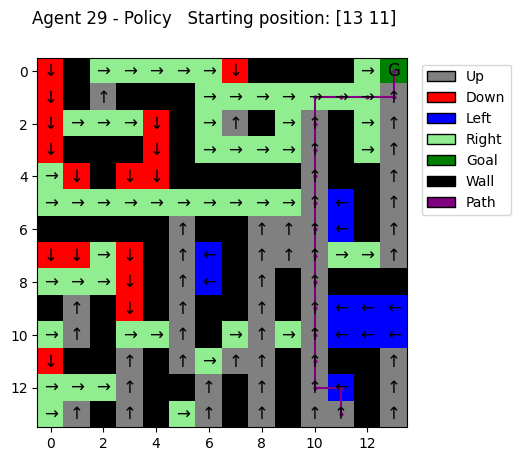

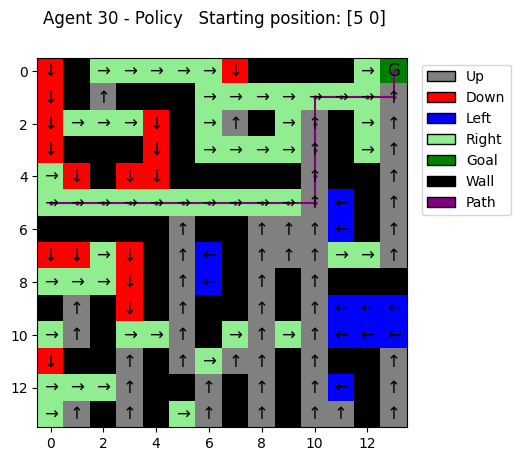

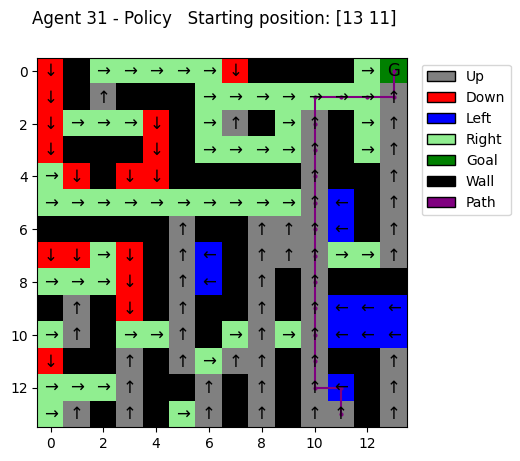

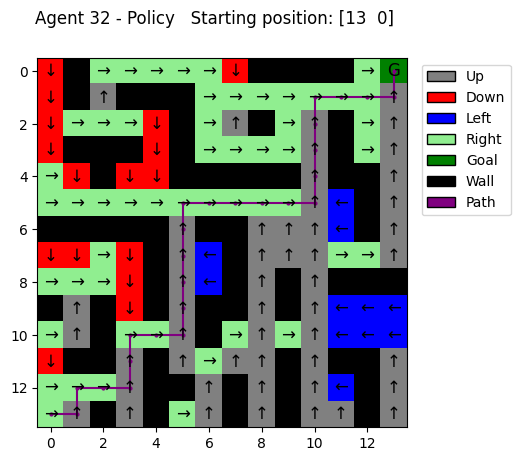

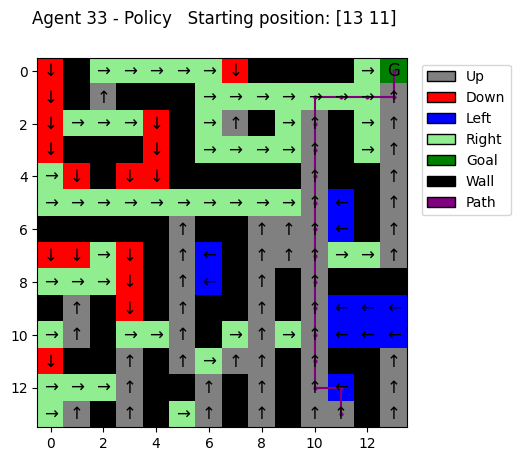

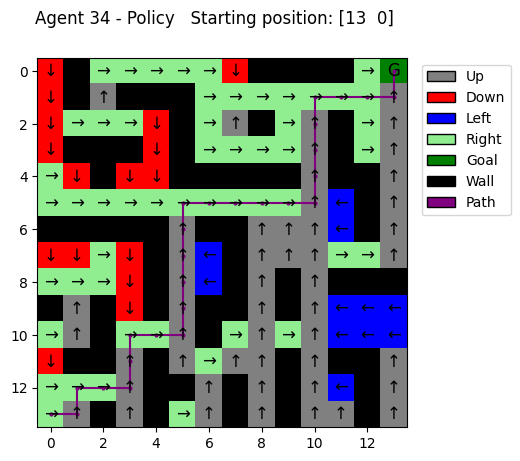

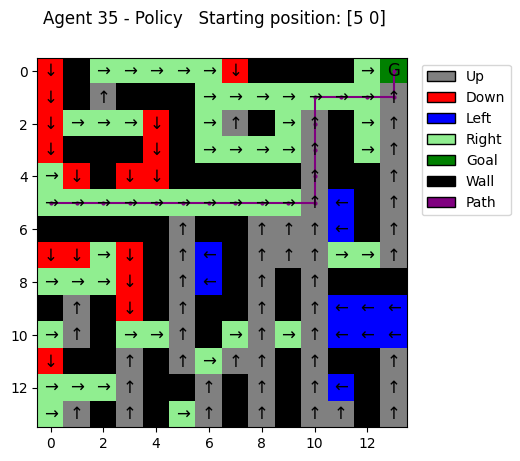

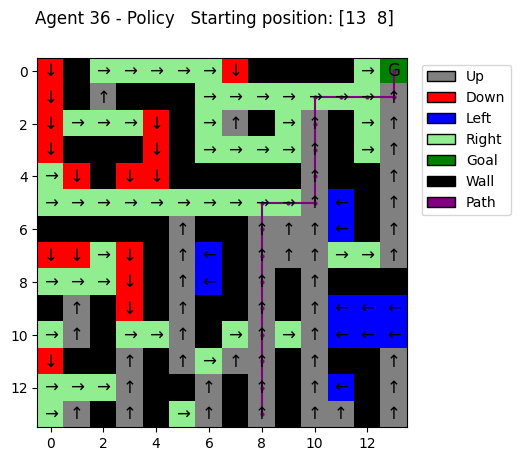

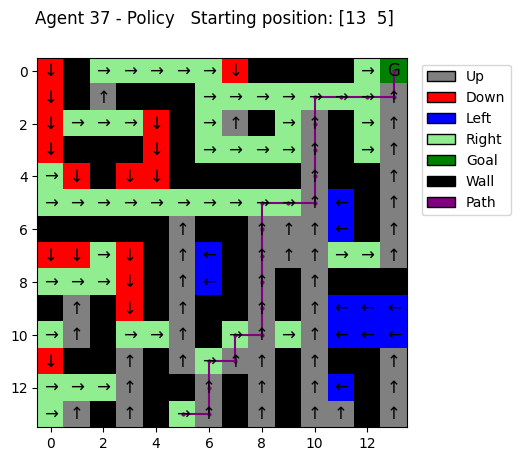

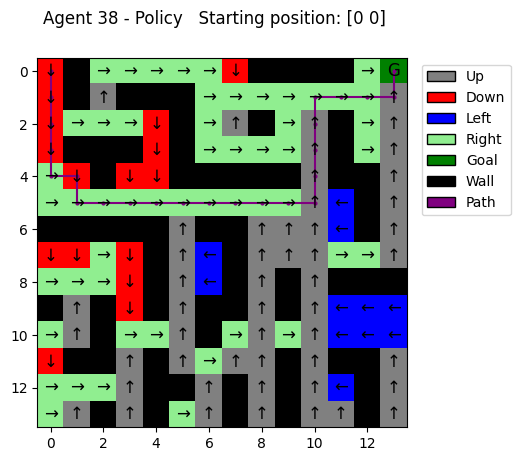

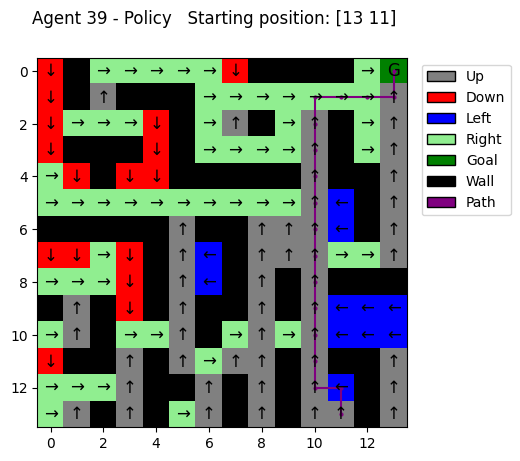

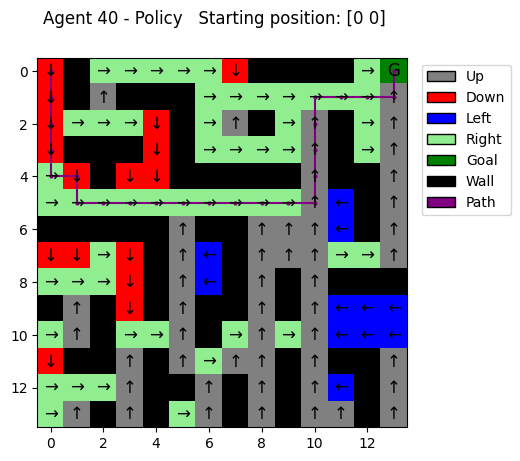

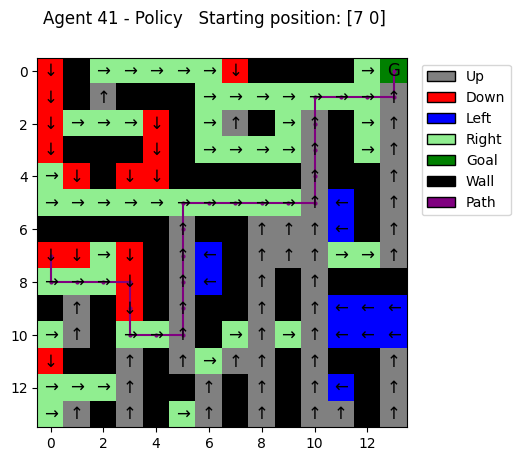

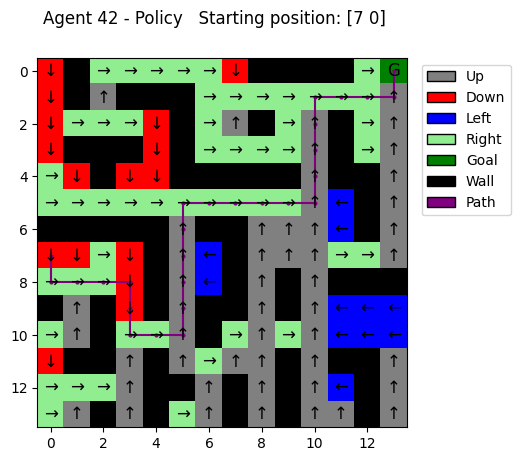

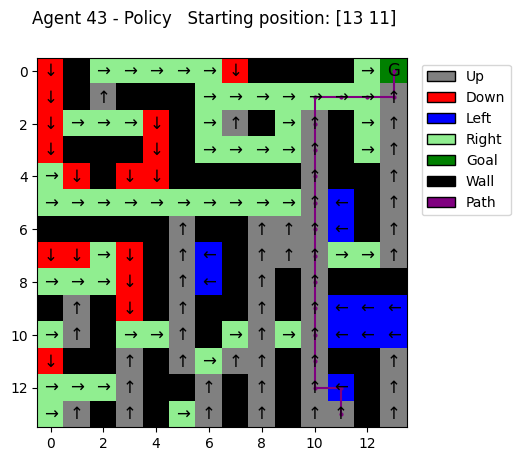

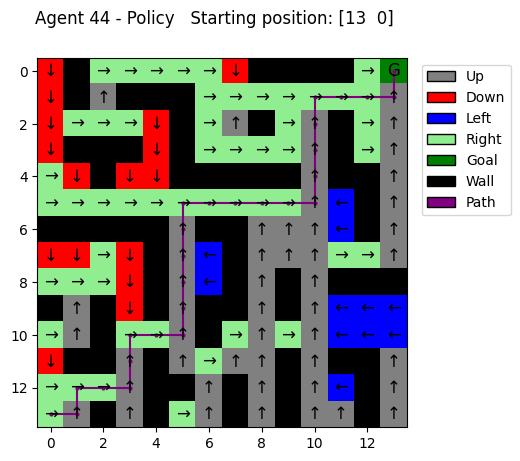

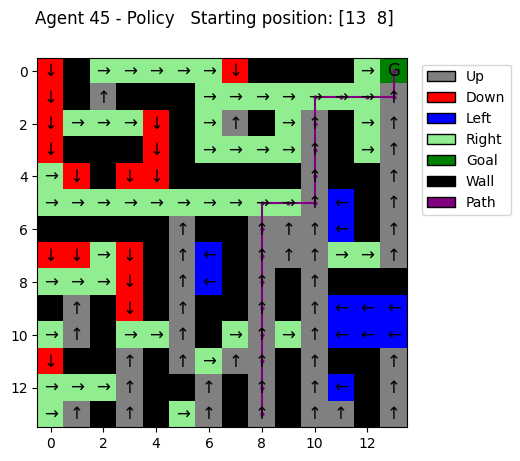

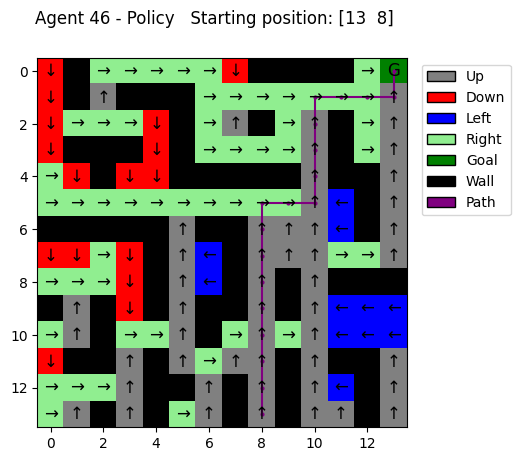

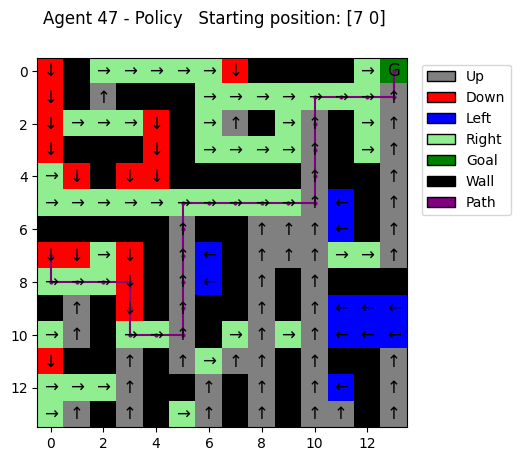

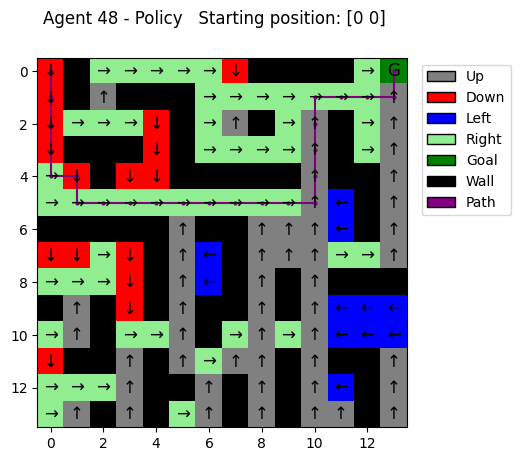

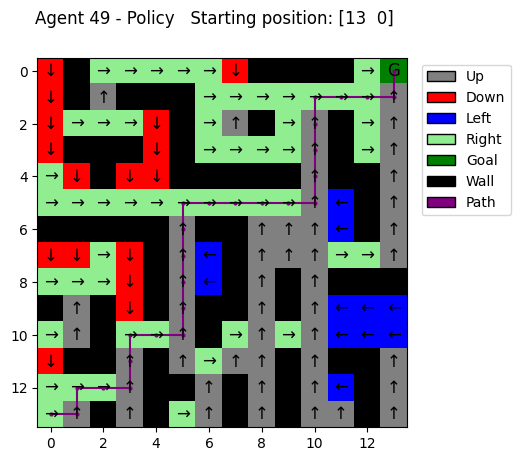

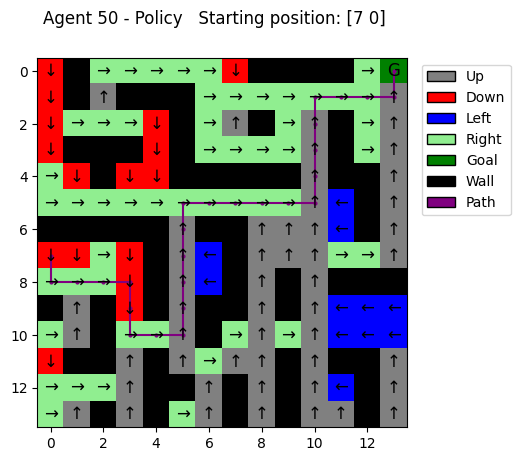

In [6]:
if train:
    for i in range(len(agents_arr)):
        value_grid, policy_grid, string_policy_grid = create_grids(env, agent=agent)

        if export_to_JSON:
            writeJSON("Q-Learning", n_episodes, 0, shape, starting_positions[i], value_grid, policy_grid, string_policy_grid)
    
        if render:
            fig = plot_trajectory(string_policy_grid, starting_positions[i])
            fig.suptitle(f'Agent {i+1} - Policy   Starting position: {starting_positions[i]}')
            plt.show()